# Reconocimiento de Patrones
[Curso de Reconocimiento de Patrones]

Departamento Electrónica

Universidad Popular del Cesar

José Ramón Iglesias

---

# Ejemplo: Extracción y Selección de Caracteristicas Geométricas

En este ejemplo se muestra cómo extraer y seleccionar características geométricas para separar 5 caracteres (A,B,X,Y,Z).




# Setup inicial

Liberías necesarias para que funcione el algoritmo.

## Setup de librerías

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from   sklearn.metrics import confusion_matrix, accuracy_score
from   seaborn import heatmap
from   tqdm.auto import tqdm
from   sklearn.neighbors import KNeighborsClassifier

from   upcele.fx.geo import fourierdes, hugeo, flusser, gupta,basicgeo
from   upcele.fs.sel import sfs,clean
from   upcele.ft.norm import minmax
from   upcele.fs.sel import jfisher,sfs
from   upcele.io.misc import imageload


from   scipy.ndimage.morphology import binary_fill_holes
from   skimage.morphology import disk,dilation


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_142124\3322555126.py:16: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from   scipy.ndimage.morphology import binary_fill_holes


# Ejemplo: Reconocimiento de 5 caracteres

En este ejemplo se realiza la extracción de características necesarias para realizar un reconocimiento de los caracteres A,B,X,Y,Z con diversos tamaños y diversas orientaciones. 


Para la solución se utiliza los descriptores ya que son invariantes a la rotación y a la escala. 




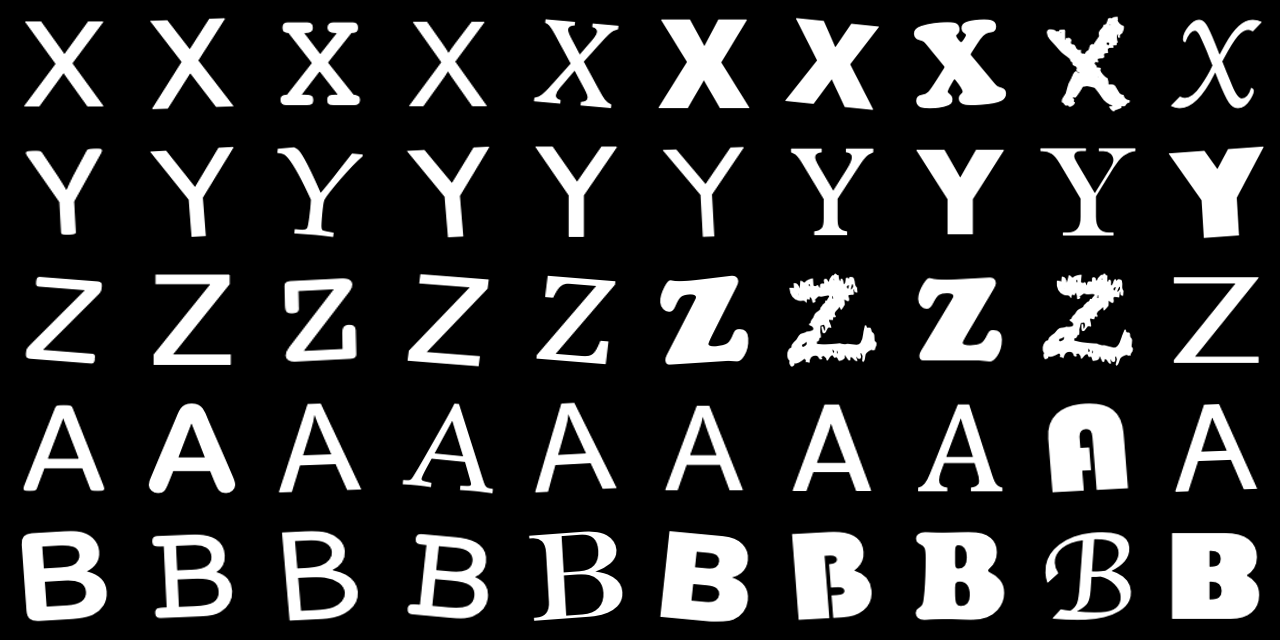

# Carga de base de datos

La base de datos consiste en 5 clases y 100 imágenes por clase

In [3]:
# Carga de base de datos
!wget https://www.dropbox.com/s/18poez6tafn01pe/ABXYZ.zip?dl=0
!unzip -qq ABXYZ.zip

--2023-03-27 18:50:24--  https://www.dropbox.com/s/chu9wdqyzqxb02j/ABXYZ.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/chu9wdqyzqxb02j/ABXYZ.zip [following]
--2023-03-27 18:50:24--  https://www.dropbox.com/s/raw/chu9wdqyzqxb02j/ABXYZ.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce0048971cf3841755bb6a94945.dl.dropboxusercontent.com/cd/0/inline/B5CHPDJFth0n5npVHOufq4VHDxFocvlut0itk4eHMCwq8NnVUmwAkVEt1mcqVdEKqH7bE8pKJkRxDD0mgAuLrtOSzYw2XQcFg63RCLFI5WcQKGA9Wsqz5iLA1JgvFOivuP8KKNeyX0IqsWePfJgOQtollG777iy603NMItDnpLAThA/file# [following]
--2023-03-27 18:50:24--  https://uce0048971cf3841755bb6a94945.dl.dropboxusercontent.com/cd/0/inline/B5CHPDJFth0n5npVHOufq4VHDxFocvlut0itk4eHMCwq8NnVUmwAkVEt1mcqVdEKqH7bE8pKJkRxDD0mgAuLrtOSz

# Funciones necesarias

In [2]:

# Separación entre training y testing
def SplitTrainTest(X,y,n):

  K      = int(np.max(y)+1)      # número de clases
  N      = int(X.shape[0]/K)     # numeros de muestras por clase
  Ntrain = n*K                      # número de muestras para el training
  Ntest  = K*N-Ntrain               # número de muestras para el testing
  M      = X.shape[1]               # número de características por muestra
  Xtrain = np.zeros((Ntrain,M))     # subset de training
  ytrain = np.zeros((Ntrain),int)   # ground truth del training         
  Xtest  = np.zeros((Ntest,M))      # subset de testing
  ytest  = np.zeros((Ntest),int)    # ground truth del testing  

  # contadores
  itrain = 0
  itest  = 0
  t      = 0


  for j in range(K):     # para cada clase
    for i in range(N):   # para cada imagen de la clase
      if i<n: # training
        Xtrain[itrain,:] = X[t,:]
        ytrain[itrain] = y[t]
        itrain = itrain+1
      else:  # testing
        Xtest[itest,:] = X[t,:]
        ytest[itest] = y[t]
        itest = itest+1
      t = t+1
  
  return Xtrain,ytrain,Xtest,ytest

# Clasificación usando KNN con 1 vecino
def ClassifierKNN(Xtrain,ytrain,Xtest,ytest,n_vecinos=1,echo ='on'):
  #Xtrain, a, b = normalize(Xtrain)
  #Xtest        = Xtest * a + b
  knn = KNeighborsClassifier(n_neighbors=n_vecinos)
  knn.fit(Xtrain, ytrain)
  ypred        = knn.predict(Xtest)
  acc          = accuracy_score(ytest,ypred)
  C = confusion_matrix(ytest,ypred)
  if echo == 'on':
    print('Entrenando con '+str(Xtrain.shape[0])+' muestras y probando con '+str(Xtest.shape[0])+' muestras')
    print('Los datos tienen '+str(Xtrain.shape[1])+' features')
    print('Testing Accuracy = '+str(acc*100)+'%')
    print('Matriz de Confusión:')
    print(C)
  return acc,C

# Extracción de Características Geométricas

In [3]:
K = 5  # número de clases
N = 100 # número de imágenes por clase

# Basico geometric features
Mbg  = 16                                 # los descriptores son 16
Xbg = np.zeros((K*N,Mbg))                 # K x N muestras (filas), y M características (columnas)

# Fourier descriptors
Mfd  = 16                                  # los descriptores son 16
Xfd = np.zeros((K*N,Mfd))                 # K x N muestras (filas), y M características (columnas)

# Hu moments
Mhu  = 7                                  # los momentos son 7
Xhu = np.zeros((K*N,Mhu))                 # K x N muestras (filas), y M características (columnas)

# Flusser moments
Mfl  = 4                                  # los momentos son 4
Xfl = np.zeros((K*N,Mfl))                 # K x N muestras (filas), y M características (columnas)

# Gupta moments
Mgu  = 3                                  # los momentos son 3
Xgu = np.zeros((K*N,Mgu))                 # K x N muestras (filas), y M características (columnas)

y = np.zeros((K*N,))                # ground truth (clasificacion ideal)

t = 0
for j in range(K):                  # para cada clase
  for i in tqdm(range(N)):                # para cada imagen de la clase
    # Lectura de la imagen
    img      = imageload('ABXYZ/char_',j+1,2,i+1,3,echo='off')
    img3     = dilation(img,disk(3))# cierra bien el 3 las A
    R        = img3 > 0.5
    R        = binary_fill_holes(R).astype(int) # imagen con relleno de agujeros
    #R = R>0*1
    Xfd[t,:] = fourierdes(R)
    Xhu[t,:] = hugeo(R)
    Xfl[t,:] = flusser(R)
    Xgu[t,:] = gupta(R)
    Xbg[t,:] = basicgeo(R)

    y[t] = j
    t = t+1

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Estrategia Básica

0. Selección Manual $\rightarrow$ 

1. Definición de características Originales $\rightarrow$ 

2. Clean $\rightarrow$ 

3. Normalización $\rightarrow$ 

4. Selección con SFS $\rightarrow$

## 0) Selección Manual
Sólo deben procesarse características invariantes a la rotación y traslación, para evitar falsa correlaciones.

In [4]:
x,xn = basicgeo(R,names='True')

for k in range(16):
  print(k,xn[k])

0 i_m
1 j_m
2 height
3 width
4 area
5 perimeter
6 roundness
7 euler_number
8 equivalent_diameter
9 major_axis
10 minor_axis
11 orientation
12 solidity
13 extent
14 eccentricity
15 convex_area_convex


In [5]:
sgeo = [2,3,4,5,6,7,8,9,10,12,13,14,15] 
Xbg2 = Xbg[:,sgeo]  # <- nuevas características geométricas básicas

## 1) Definición de Input, Training y Testing original

In [6]:
# Defincion de Input

X_original = np.concatenate((Xbg2,Xfd,Xhu,Xfl,Xgu),axis=1)

# Defincion de Training/Testing

Xtrain_original,ytrain,Xtest_original,ytest = SplitTrainTest(X_original,y,75)

In [7]:
np.save('Letras_X',X_original)
np.save('Letras_y',y)


In [8]:
# Clasificacion con datos originales

acc,C = ClassifierKNN(Xtrain_original,ytrain,Xtest_original,ytest)


Entrenando con 375 muestras y probando con 125 muestras
Los datos tienen 43 features
Testing Accuracy = 69.6%
Matriz de Confusión:
[[17  2  1  1  4]
 [ 0 20  4  1  0]
 [ 1  2 17  1  4]
 [ 6  0  0 14  5]
 [ 0  5  0  1 19]]


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


## 2) Cleaning

In [9]:
# Cleaning

sclean = clean(Xtrain_original)            # índice de características seleccionadas
Xtrain_clean = Xtrain_original[:,sclean]   # nuevo training
Xtest_clean  = Xtest_original[:,sclean]    # nuevo testing

print(sclean)
print(sclean.shape)


[ 0  1  2  3  4  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 39 40 41 42]
(40,)


In [10]:
# Clasificacion con datos "limpios"

acc,C = ClassifierKNN(Xtrain_clean,ytrain,Xtest_clean,ytest,1)


Entrenando con 375 muestras y probando con 125 muestras
Los datos tienen 40 features
Testing Accuracy = 69.6%
Matriz de Confusión:
[[17  2  1  1  4]
 [ 0 20  4  1  0]
 [ 1  2 17  1  4]
 [ 6  0  0 14  5]
 [ 0  5  0  1 19]]


## 3) Normalización

In [11]:
# Normalización

Xtrain_norm, a, b = minmax(Xtrain_clean)
Xtest_norm        = Xtest_clean * a + b

In [12]:
# Clasificacion con datos normalizados

acc,C = ClassifierKNN(Xtrain_norm,ytrain,Xtest_norm,ytest,1)


Entrenando con 375 muestras y probando con 125 muestras
Los datos tienen 40 features
Testing Accuracy = 77.60000000000001%
Matriz de Confusión:
[[17  0  2  6  0]
 [ 0 25  0  0  0]
 [ 5  0 20  0  0]
 [ 5  0  0 16  4]
 [ 0  0  0  6 19]]


## 4) SFS



In [13]:
# Implementacion manual
def sfs_fisher(X,y,p):
  m = X.shape[1]
  disponibles = np.ones((m,))
  seleccionadas = -np.ones((p,),int)
  Jmax = 0
  for j in tqdm(range(p)):
    for k in range(m):
      if disponibles[k]:
        seleccionadas[j] = k
        columnas = seleccionadas[0:j+1]
        Xsel = X[:,columnas]
        J = jfisher(Xsel,y)
        if J > Jmax:
          Jmax = J
          ksel = k
          print('> selected: J('+str(columnas)+') = '+str(J/100))
    disponibles[ksel] = 0
    seleccionadas[j] = ksel
  return seleccionadas


In [14]:
# Selección con SFS - Fisher
p  = 8 # numero de caracteristicas a seleccionar
ss = sfs_fisher(Xtrain_norm,ytrain,p)

  0%|          | 0/8 [00:00<?, ?it/s]

> selected: J([0]) = 4.4453444901265056e-05
> selected: J([1]) = 0.0012298941077666195
> selected: J([2]) = 0.005908993352206651
> selected: J([3]) = 0.0066519533009119555
> selected: J([4]) = 0.03811883620597881
> selected: J([12]) = 0.06072655506861238
> selected: J([13]) = 0.14688281034968878
> selected: J([13  0]) = 0.14959306759548144
> selected: J([13  1]) = 0.15376574292072565
> selected: J([13  3]) = 0.18285210331711213
> selected: J([13  4]) = 0.26254982264393695
> selected: J([13 12]) = 0.2726467173803431
> selected: J([13 12  0]) = 0.2747012119312428
> selected: J([13 12  1]) = 0.27958686110805425
> selected: J([13 12  2]) = 0.287058697096118
> selected: J([13 12  3]) = 0.29183735054272253
> selected: J([13 12  4]) = 0.3619395767067882
> selected: J([13 12  4  0]) = 0.36480035054251725
> selected: J([13 12  4  1]) = 0.3699956681692324
> selected: J([13 12  4  2]) = 0.38531030319822746
> selected: J([13 12  4 11]) = 0.4061872564936928
> selected: J([13 12  4 17]) = 0.41094116

In [15]:
# Implementacion con librería upcele
ss = sfs(Xtrain_norm,ytrain,p)
print(ss)

[13 12  4 17 14 11 38 24]


In [16]:
Xtrain_sel = Xtrain_norm[:,ss]
Xtest_sel  = Xtest_norm[:,ss]

In [17]:
# Clasificación con 8 caracteristicas seleccionadas

acc,C = ClassifierKNN(Xtrain_sel,ytrain,Xtest_sel,ytest,1)


Entrenando con 375 muestras y probando con 125 muestras
Los datos tienen 8 features
Testing Accuracy = 92.0%
Matriz de Confusión:
[[23  0  2  0  0]
 [ 0 23  0  2  0]
 [ 0  0 25  0  0]
 [ 0  0  0 25  0]
 [ 0  0  0  6 19]]
